## Implementing a CGAN for the Iris data set to generate synthetic data
Import necessary modules and packages

In [1]:
import os
while os.path.basename(os.getcwd()) != 'Synthetic_Data_GAN_Capstone':
    os.chdir('..')
safe_mkdir('experiments')
from scripts.Utils.data_loading import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.VGAN import VGAN_Generator, VGAN_Discriminator
from models.CGAN_iris import CGAN_Generator, CGAN_Discriminator
from scripts.Utils.utils import *
import random

Set random seed for reproducibility

In [2]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Load data

In [3]:
iris = load_dataset('iris')
iris.head()

,sepal_len,sepal_wid,petal_len,petal_wid,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Split 50-50 so we can demonstrate the effectiveness of additional data

In [4]:
x_train, x_test, y_train, y_test = train_test_split(iris.drop(columns='species'), iris.species, test_size=0.5, stratify=iris.species, random_state=manualSeed)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

x_train: (75, 4)
x_test: (75, 4)


Model parameters (feel free to play with these)

In [5]:
nz = 32  # Size of generator noise input
H = 16  # Size of hidden network layer
out_dim = x_train.shape[1]  # Size of output
bs = x_train.shape[0]  # Full data set
nc = 3  # 3 different types of label in this problem
num_batches = 1
num_epochs = 10000
exp_name = 'experiments/iris_1x16'
safe_mkdir(exp_name)

Adam optimizer hyperparameters (set based on the original paper, but feel free to play with as well)

In [6]:
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

Set the device (Recommend running on a GPU)

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

Scale inputs for neural networks

In [8]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train_tensor = torch.tensor(x_train, dtype=torch.float)
y_train_dummies = pd.get_dummies(y_train)
y_train_dummies_tensor = torch.tensor(y_train_dummies.values, dtype=torch.float)

Instantiate nets

In [9]:
netG = CGAN_Generator(nz=nz, H=H, out_dim=out_dim, nc=nc, bs=bs, lr=lr, beta1=beta1, beta2=beta2).to(device)
netD = CGAN_Discriminator(H=H, out_dim=out_dim, nc=nc, lr=lr, beta1=beta1, beta2=beta2).to(device)

Print models (I chose to avoid using sequential mode in case I wanted to create non-sequential networks, it is more flexible in my opinion, but does not print out as nicely)

In [10]:
print(netG)
print(netD)

CGAN_Generator(
  (fc1): Linear(in_features=35, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=4, bias=True)
  (act): LeakyReLU(negative_slope=0.2)
  (loss_fn): BCELoss()
)
CGAN_Discriminator(
  (fc1): Linear(in_features=7, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
  (act): LeakyReLU(negative_slope=0.2)
  (m): Sigmoid()
  (loss_fn): BCELoss()
)


Define labels

In [11]:
real_label = 1
fake_label = 0

# Training Loop
Look through the comments to better understand the steps that are taking place

In [12]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i in range(num_batches):  # Only one batch per epoch since our data is horrifically small
        # Update Discriminator
        # All real batch first
        real_data = x_train_tensor.to(device)  # Format batch (entire data set in this case)
        real_classes = y_train_dummies_tensor.to(device)
        label = torch.full((bs,), real_label, device=device)  # All real labels

        output = netD(real_data, real_classes).view(-1)  # Forward pass with real data through Discriminator
        netD.train_one_step_real(output, label)

        # All fake batch next
        noise = torch.randn(bs, nz, device=device)  # Generate batch of latent vectors
        fake = netG(noise, real_classes)  # Fake image batch with netG
        label.fill_(fake_label)
        output = netD(fake.detach(), real_classes).view(-1)
        netD.train_one_step_fake(output, label)
        netD.combine_and_update_opt()
        netD.update_history()

        # Update Generator
        label.fill_(real_label)  # Reverse labels, fakes are real for generator cost
        output = netD(fake, real_classes).view(-1)  # Since D has been updated, perform another forward pass of all-fakes through D
        netG.train_one_step(output, label)
        netG.update_history()

        # Output training stats
        if epoch % 1000 == 0 or (epoch == num_epochs-1):
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, netD.loss.item(), netG.loss.item(), netD.D_x, netD.D_G_z1, netG.D_G_z2))
            with torch.no_grad():
                fake = netG(netG.fixed_noise, real_classes).detach().cpu()
            netG.fixed_noise_outputs.append(scaler.inverse_transform(fake))
print("Training Complete")

Starting Training Loop...
[1/10000]	Loss_D: 1.4505	Loss_G: 0.6407	D(x): 0.4969	D(G(z)): 0.5270 / 0.5270
[1001/10000]	Loss_D: 1.3275	Loss_G: 0.7261	D(x): 0.5203	D(G(z)): 0.4871 / 0.4870
[2001/10000]	Loss_D: 1.3871	Loss_G: 0.6925	D(x): 0.5000	D(G(z)): 0.5003 / 0.5003
[3001/10000]	Loss_D: 1.3859	Loss_G: 0.6934	D(x): 0.5003	D(G(z)): 0.5000 / 0.4999
[4001/10000]	Loss_D: 1.3868	Loss_G: 0.6917	D(x): 0.5007	D(G(z)): 0.5008 / 0.5008
[5001/10000]	Loss_D: 1.3851	Loss_G: 0.6930	D(x): 0.5008	D(G(z)): 0.5001 / 0.5001
[6001/10000]	Loss_D: 1.3808	Loss_G: 0.6963	D(x): 0.5013	D(G(z)): 0.4985 / 0.4985
[7001/10000]	Loss_D: 1.3804	Loss_G: 0.6975	D(x): 0.5009	D(G(z)): 0.4979 / 0.4979
[8001/10000]	Loss_D: 1.3796	Loss_G: 0.6978	D(x): 0.5012	D(G(z)): 0.4978 / 0.4978
[9001/10000]	Loss_D: 1.3790	Loss_G: 0.6978	D(x): 0.5016	D(G(z)): 0.4978 / 0.4978
[10000/10000]	Loss_D: 1.3826	Loss_G: 0.6944	D(x): 0.5016	D(G(z)): 0.4996 / 0.4994
Training Complete


## Output diagnostic plots tracking training progress and statistics

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


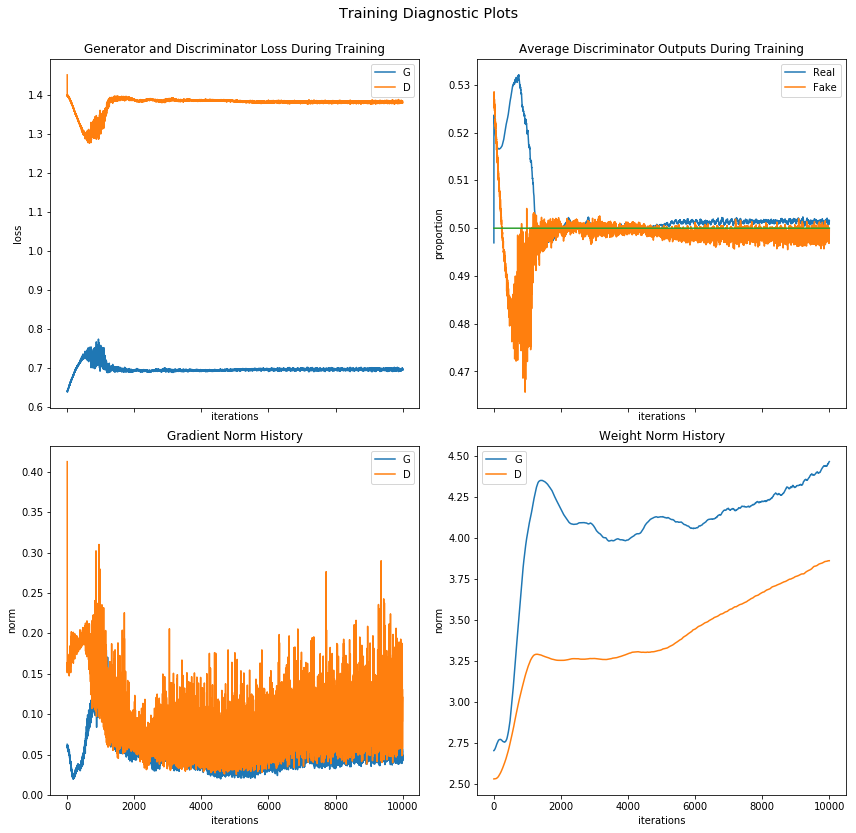

In [13]:
%matplotlib inline
training_plots(netD=netD, netG=netG, num_epochs=num_epochs, save=exp_name)

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


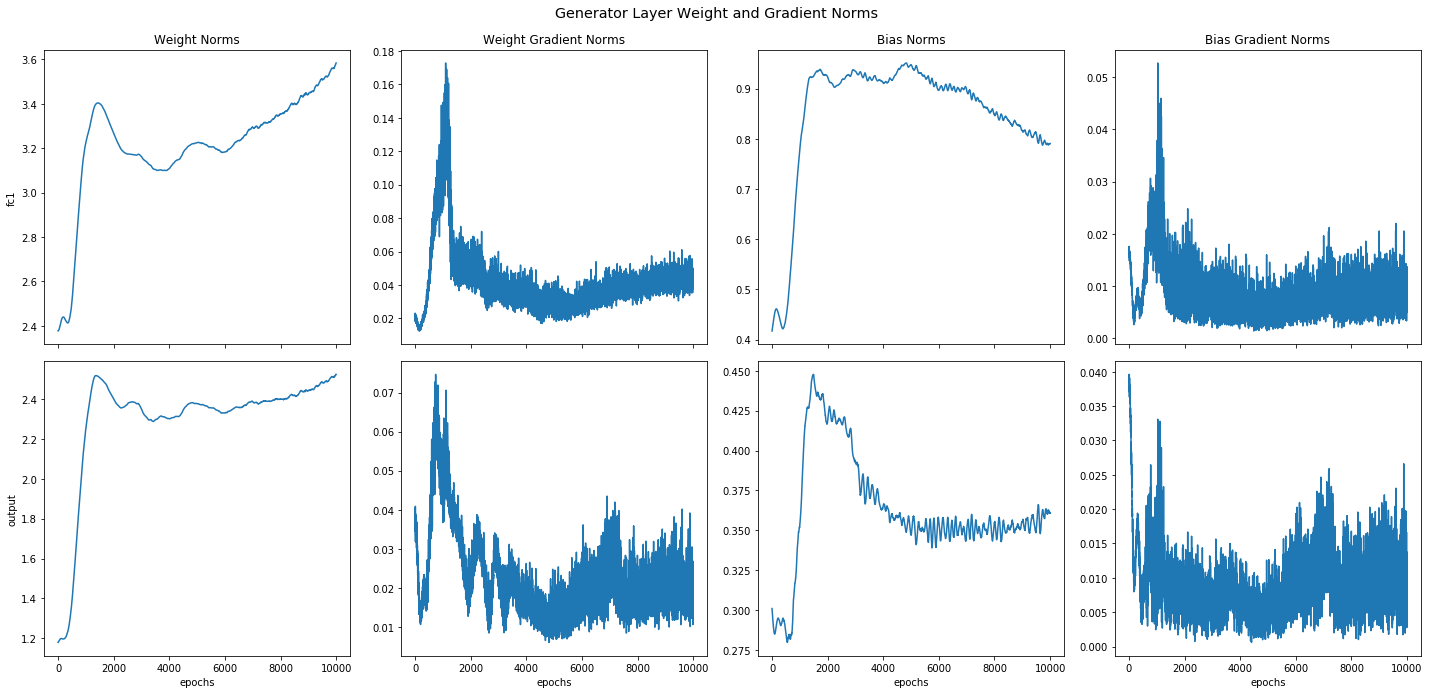

In [14]:
plot_layer_scatters(netG, title="Generator", save=exp_name)

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


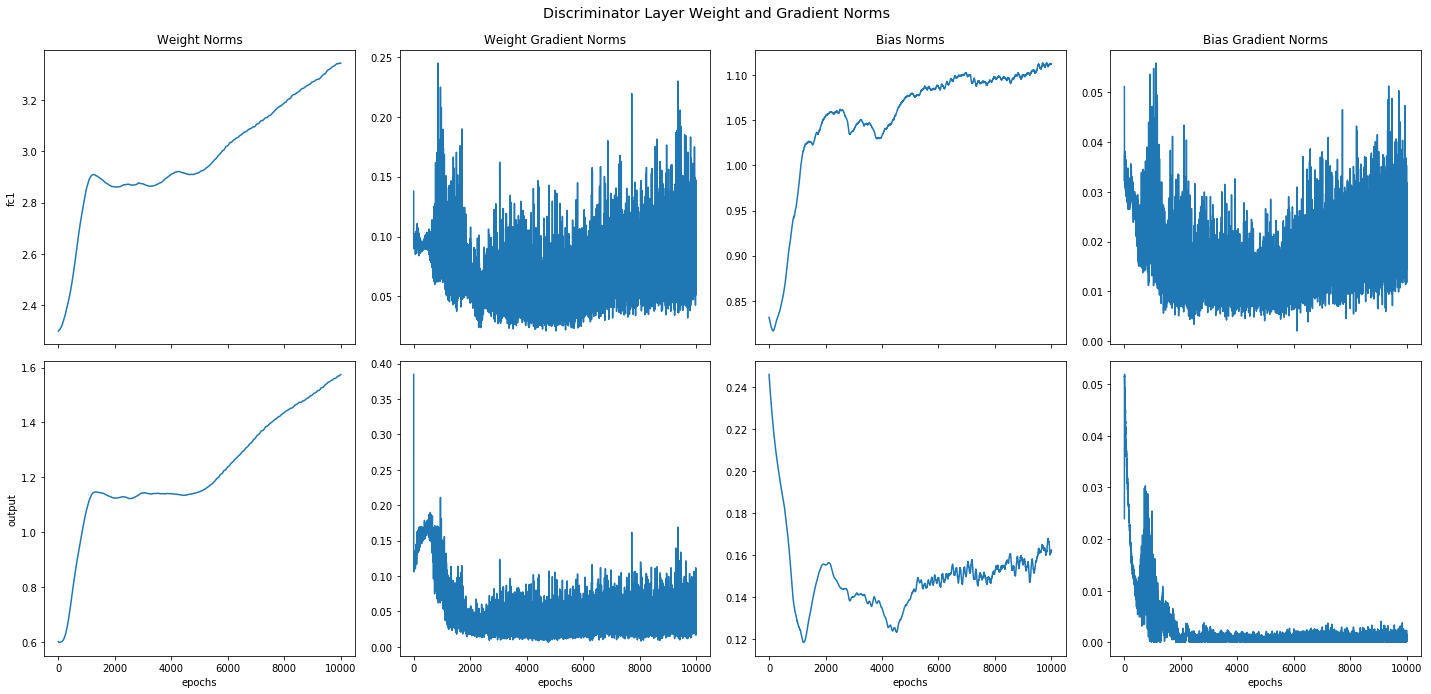

In [15]:
plot_layer_scatters(netD, title="Discriminator", save=exp_name)

It looks like training stabilized fairly quickly, after only a few thousand iterations. The fact that the weight norm increased over time probably means that this network would benefit from some regularization.

# Compare performance of training on fake data versus real data
In this next section, we will lightly tune two models via cross-validation. The first model will be trained on the 75 real training data examples and tested on the remaining 75 testing data examples, whereas the second set of models will be trained on different amounts of generated data (no real data involved whatsoever). We will then compare performance and plot some graphs to evaluate our CGAN.

In [16]:
y_test_dummies = pd.get_dummies(y_test)
print("Dummy columns match?", all(y_train_dummies.columns == y_test_dummies.columns))
x_test = scaler.transform(x_test)
labels_list = [x for x in y_train_dummies.columns]
param_grid = {'tol': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
              'C': [0.5, 0.75, 1, 1.25],
              'l1_ratio': [0, 0.25, 0.5, 0.75, 1]}

Dummy columns match? True


Train on real data

In [17]:
model_real, score_real = train_test_logistic_reg(x_train, y_train, x_test, y_test, param_grid=param_grid, cv=5, random_state=manualSeed, labels=labels_list)

Accuracy: 0.92
Best Parameters: {'C': 1.25, 'l1_ratio': 0.5, 'tol': 1e-09}
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        25
Iris-versicolor       0.85      0.92      0.88        25
 Iris-virginica       0.91      0.84      0.87        25

       accuracy                           0.92        75
      macro avg       0.92      0.92      0.92        75
   weighted avg       0.92      0.92      0.92        75

[[25  0  0]
 [ 0 23  2]
 [ 0  4 21]]


Train on various levels of fake data

In [18]:
test_range = [75, 150, 300, 600, 1200]
fake_bs = bs
fake_models = []
fake_scores = []
for size in test_range:
    num_batches = size // fake_bs + 1
    genned_data = np.empty((0, out_dim))
    genned_labels = np.empty(0)
    rem = size
    while rem > 0:
        curr_size = min(fake_bs, rem)
        noise = torch.randn(curr_size, nz, device=device)
        fake_labels, output_labels = gen_labels(size=curr_size, num_classes=nc, labels_list=labels_list)
        fake_labels = fake_labels.to(device)
        rem -= curr_size
        fake_data = netG(noise, fake_labels).cpu().detach().numpy()
        genned_data = np.concatenate((genned_data, fake_data))
        genned_labels = np.concatenate((genned_labels, output_labels))
    print("For size of:", size)
    model_fake_tmp, score_fake_tmp = train_test_logistic_reg(genned_data, genned_labels, x_test, y_test,
                                                             param_grid=param_grid, cv=5, random_state=manualSeed, labels=labels_list)
    fake_models.append(model_fake_tmp)
    fake_scores.append(score_fake_tmp)

For size of: 75
Accuracy: 0.92
Best Parameters: {'C': 0.5, 'l1_ratio': 1, 'tol': 1e-09}
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        25
Iris-versicolor       0.85      0.92      0.88        25
 Iris-virginica       0.91      0.84      0.87        25

       accuracy                           0.92        75
      macro avg       0.92      0.92      0.92        75
   weighted avg       0.92      0.92      0.92        75

[[25  0  0]
 [ 0 23  2]
 [ 0  4 21]]
For size of: 150
Accuracy: 0.9333333333333333
Best Parameters: {'C': 0.5, 'l1_ratio': 0.5, 'tol': 1e-09}
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        25
Iris-versicolor       0.86      0.96      0.91        25
 Iris-virginica       0.95      0.84      0.89        25

       accuracy                           0.93        75
      macro avg       0.94      0.93      0.93        75
   weighted avg       0.

Well, it looks like this experiment was a success. The models trained on fake data were actually able to outperform models trained on real data, which supports the belief that the CGAN is able to understand the distribution of the data it was trained on and generate meaningful examples that can be used to add additional information to the model.

Let's visualize some of the distributions of outputs to get a better idea of what took place

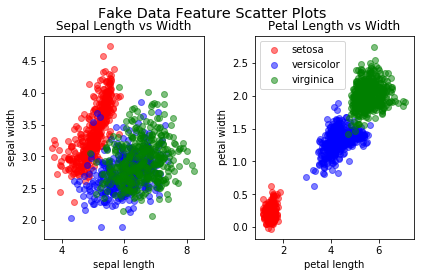

<Figure size 432x288 with 0 Axes>

In [19]:
iris_plot_scatters(genned_data, genned_labels, "Fake Data", scaler, alpha=0.5, save=exp_name)  # Fake data

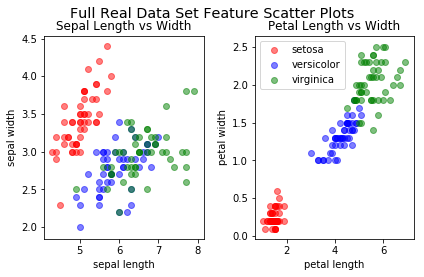

<Figure size 432x288 with 0 Axes>

In [20]:
iris_plot_scatters(iris.drop(columns='species'), np.array(iris.species), "Full Real Data Set", alpha=0.5, save=exp_name)  # All real data

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


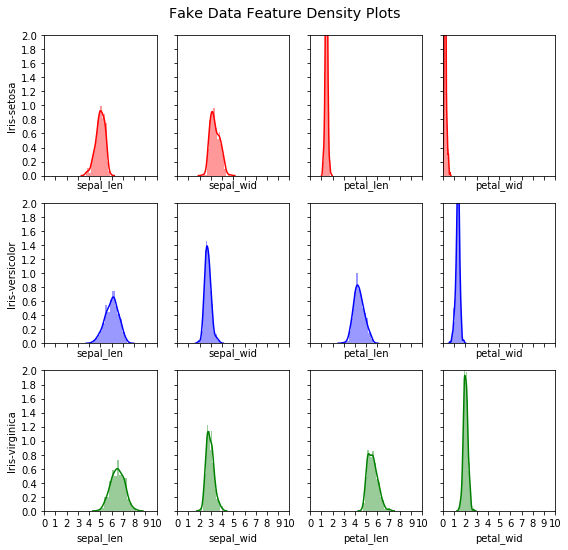

In [21]:
iris_plot_densities(genned_data, genned_labels, "Fake Data", scaler, save=exp_name)  # Fake data

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


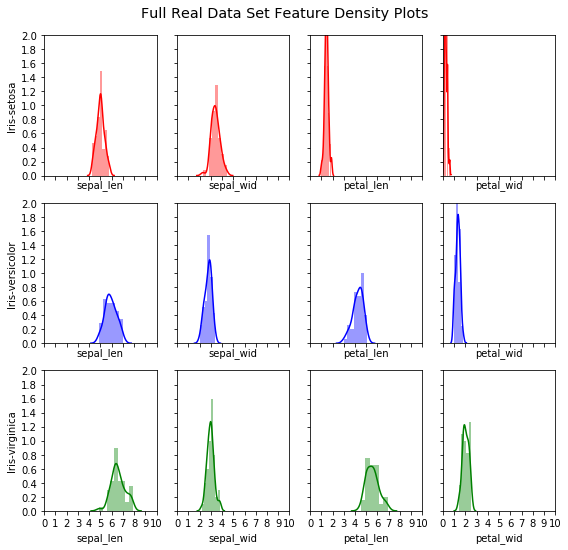

In [22]:
iris_plot_densities(iris.drop(columns='species'), np.array(iris.species), "Full Real Data Set", save=exp_name)  # All real data

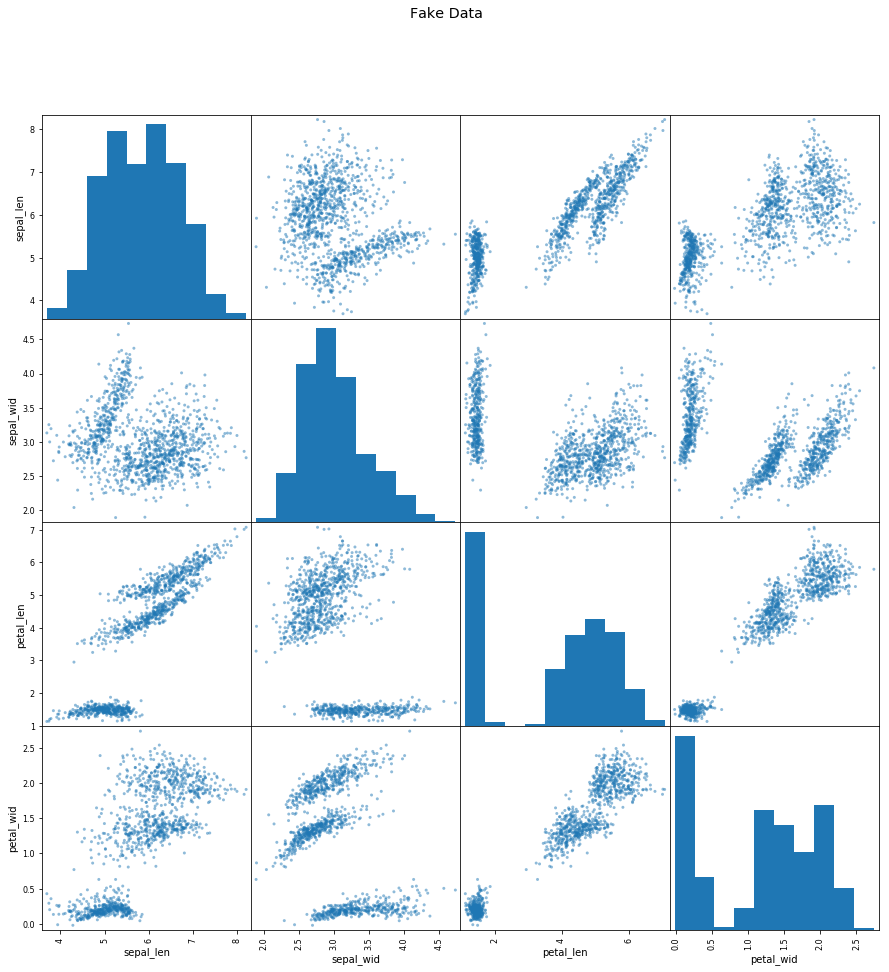

<Figure size 432x288 with 0 Axes>

In [23]:
plot_scatter_matrix(genned_data, "Fake Data", iris.drop(columns='species'), scaler=scaler, save=exp_name)

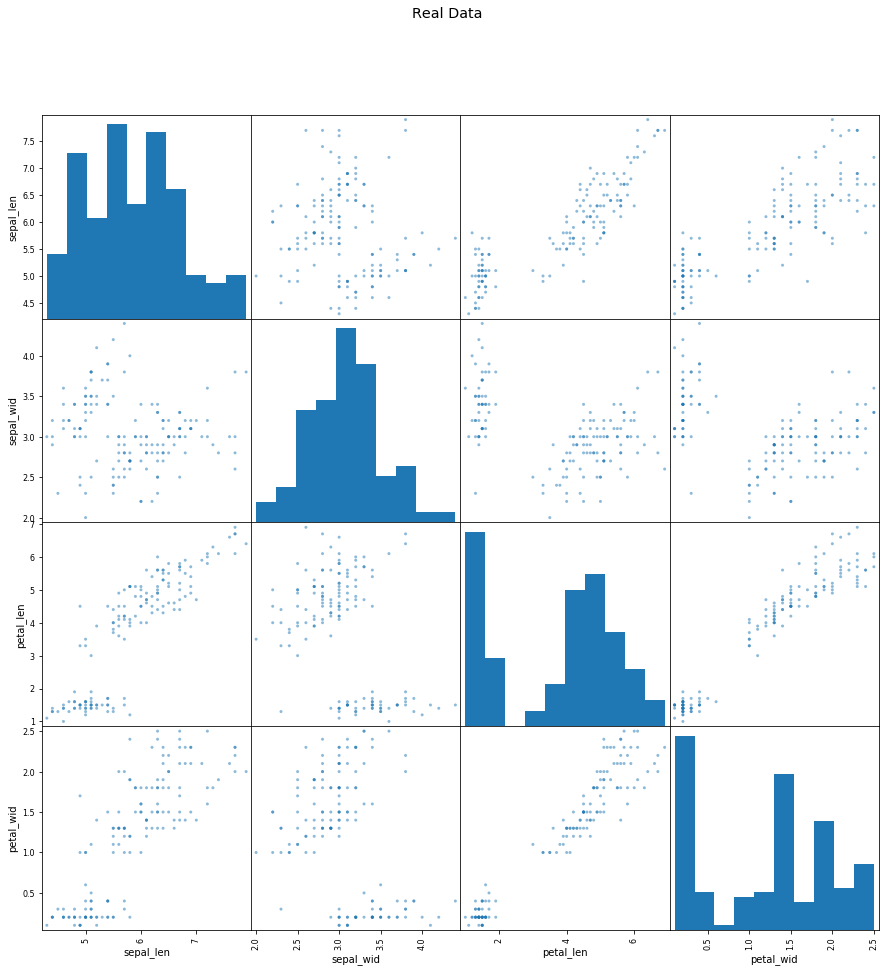

<Figure size 432x288 with 0 Axes>

In [26]:
plot_scatter_matrix(iris.drop(columns='species'), "Real Data", iris.drop(columns='species'), scaler=None, save=exp_name)

Finally, I present a summary of the test results ran above

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


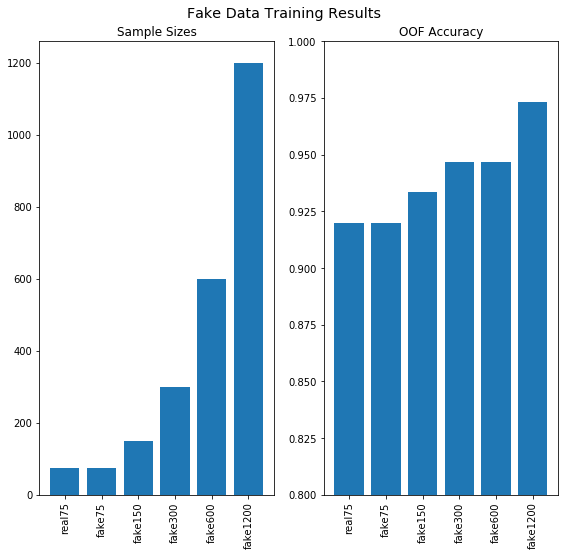

In [25]:
fake_data_training_plots(real_range=bs, score_real=score_real, test_range=test_range, fake_scores=fake_scores, save=exp_name)